**AI Research Assistant**

A simple lightweight, modular agent that leverages the ReAct framework to retrieve real-time web search results. Powered by LangGraph, this assistant demonstrates how to build custom, stateful AI workflows using open-source tools.

In [7]:
%%capture --no-stderr
%pip install -U langgraph langchain-groq langchain-openai tavily-python langchain-community arxiv

In [5]:
import os
import getpass

os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your GROQ API Key: ")
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key: ")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API Key: ")
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API Key: ")

Enter your GROQ API Key: ··········
Enter your OpenAI API Key: ··········
Enter your Tavily API Key: ··········
Enter your LangSmith API Key: ··········


In [8]:
# First we initialize the model we want to use.
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage

#model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

model = ChatGroq(model="llama-3.3-70b-versatile")
# key models: qwen-2.5-32b, deepseek-r1-distill-llama-70b, llama-3.3-70b-versatile


# For this project we will use custom tool that returns pre-defined values for currency exchange rate

from typing import Literal

from langchain_core.tools import tool
from langchain.agents import load_tools


@tool
def get_exchange_rate(currency: Literal["usd", "aed"]):
    """gets the cuurency exchange rate for the indian rupee"""
    if currency == "usd":
        return "One US dollar equals to 80 Indian rupees"
    elif currency == "aed":
        return "One AED equals to 20 Indian rupees"
    else:
        raise AssertionError("Unknown currency")

# Define the Tavily search tool
search_tool = TavilySearchResults(max_results=3)

# Load the ArXiv search tool
arxiv_tool = load_tools(["arxiv"])[0]

# List all tools including the currency exchange function
tools = [get_exchange_rate, search_tool, arxiv_tool]


# Define the graph

from langgraph.prebuilt import create_react_agent

graph = create_react_agent(model, tools=tools)

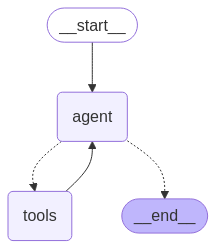

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Beautified print_stream function
from IPython.display import Markdown, display
def print_stream(stream):
    """
    Beautifies the output of the agent's response stream in a Jupyter notebook.
    Uses Markdown for formatting and adds some styling.
    """
    full_response = ""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            # Handle tuple messages (e.g., tool calls)
            content = f"**Tool Call**: {message[0]}\n\nDetails: {message[1]}"
            full_response += content + "\n\n"
        else:
            # Handle regular messages (e.g., HumanMessage, AIMessage)
            role = message.type.capitalize()
            content = message.content
            if role == "Human":
                full_response += f"### 👤 {role}\n{content}\n\n"
            elif role == "Ai":
                full_response += f"### 🤖 {role} Response\n{content}\n\n"
            else:
                full_response += f"### {role}\n{content}\n\n"

    # Display the full response as Markdown
    display(Markdown(full_response))

In [11]:
#Let's run the app with an input that needs a tool call

inputs = {"messages": [("user", "what is the usd exchange rate?")]}
print_stream(graph.stream(inputs, stream_mode="values", config={"recursion_limit": 10}))

### 👤 Human
what is the usd exchange rate?

### 🤖 Ai Response


### Tool
One US dollar equals to 80 Indian rupees

### 🤖 Ai Response
The current exchange rate for 1 USD is 82.75 INR.



In [12]:
#A question that doesn't need tools

from datetime import date
from langchain.schema import SystemMessage, HumanMessage

today = date.today().strftime("%B %d, %Y")  # Example: April 05, 2025

query = {
    "messages": [
        SystemMessage(
            content="You are an AI research assistant with expertise in summarizing latest news on provided."
        ),
        HumanMessage(
            content=f"""
Provide a concise summary of the latest advancements in Quantum Computing as of {today}.
Please include references to original sources (links or citation details) for each key point or discovery you mention.
"""
        )
    ]
}

print(query)

{'messages': [SystemMessage(content='You are an AI research assistant with expertise in summarizing latest news on provided.', additional_kwargs={}, response_metadata={}), HumanMessage(content='\nProvide a concise summary of the latest advancements in Quantum Computing as of April 07, 2025.\nPlease include references to original sources (links or citation details) for each key point or discovery you mention.\n', additional_kwargs={}, response_metadata={})]}


In [13]:
# Run the agent with a sample query
response_stream = graph.stream(query, stream_mode="values",config={"recursion_limit": 10})
print_stream(response_stream)

### 👤 Human

Provide a concise summary of the latest advancements in Quantum Computing as of April 07, 2025.
Please include references to original sources (links or citation details) for each key point or discovery you mention.


### 🤖 Ai Response


### Tool
[{"title": "2025 Will See Huge Advances in Quantum Computing. So What is a ...", "url": "https://thequantuminsider.com/2025/01/08/2025-will-see-huge-advances-in-quantum-computing-so-what-is-a-quantum-chip-and-how-does-it-work/", "content": "Building a full-scale quantum computer is a daunting task. It will require simultaneous advancements on many fronts, such as scaling up the number of qubits on a chip, improving the fidelity of the qubits, better error correction, quantum software, quantum algorithms, and several other sub-fields of quantum computing.\nAfter years of remarkable foundational work, we can expect 2025 to bring new breakthroughs in all of the above.\nquantum chipquantum computer chipThe Conversation [...] From The Conversation\nBy Muhammad Usman\nHead of Quantum Systems and Principal Research Scientist, CSIRO\nIn recent years, the field of quantum computing has been experiencing fast growth, with technological advances and large-scale investments regularly making the news.\nThe United Nations has designated 2025 as the International Year of Quantum Science and Technology. [...] Over the last 30 years, researchers have designed theoretical techniques which use many imperfect or low-fidelity qubits to encode an abstract “logical qubit”. A logical qubit is protected from errors and, therefore, has very high fidelity. A useful quantum processor will be based on many logical qubits.\nNearly all major quantum chip developers are now putting these theories into practice, shifting their focus from qubits to logical qubits.", "score": 0.74004334}, {"title": "Quantum computing's six most important trends for 2025 - Moody's", "url": "https://www.moodys.com/web/en/us/insights/quantum/quantum-computings-six-most-important-trends-for-2025.html", "content": "More experiments with logical qubits  \n\n\nMore specialized hardware/software (as opposed to universal quantum computing)  \n\n\nMore networking noisy intermediate-scale quantum (NISQ) devices together  \n\n\nMore layers of software abstraction  \n\n\nMore workforce development tools  \n\n\nImproved and novel physical qubits [...] On September 10, Microsoft and Quantinuum announced that they had entangled 12 logical qubits, triple the logical qubit count from six months prior [4]. The physical error rate of 0.024 was brought down to a logical error rate of 0.0011, leading to the first ever chemistry simulation combining high-performance computing (HPC), artificial intelligence (AI), and quality control (QC) [5]. [...] University College Dublin, “Topological quantum computers a step closer with new method to ‘split’ electrons,” Phys.org, September 19, 2024.\nBrookhaven National Laboratory, “Brookhaven Lab’s new qubit architecture could change quantum computing forever,” SciTechDaily, September 21, 2024.\nSwayne, Matt, “Research team achieves first-ever topological qubit, a step along the path toward fault-tolerant quantum computing,” The Quantum Insider, November 26, 2024.", "score": 0.71995544}, {"title": "Qubits 2025 Unveiling Quantum Annealing Breakthroughs…", "url": "https://www.youtube.com/watch?v=l_IML23HI00", "content": "The Quantum Bull New 847 views · 1:36:11 · Go to channel · Qubits 2025 ... 4/7/2025. Bloomberg Television New 4.4K views · 28:43 · Go to channel", "score": 0.5951402}]

### 🤖 Ai Response
As of April 07, 2025, the latest advancements in Quantum Computing include:

1. Huge advances in quantum computing are expected in 2025, with a focus on scaling up the number of qubits on a chip, improving the fidelity of the qubits, better error correction, quantum software, quantum algorithms, and several other sub-fields of quantum computing (Source: The Quantum Insider).
2. Researchers are shifting their focus from qubits to logical qubits, which are protected from errors and have very high fidelity (Source: The Conversation).
3. More experiments with logical qubits, specialized hardware/software, networking noisy intermediate-scale quantum (NISQ) devices together, more layers of software abstraction, workforce development tools, and improved and novel physical qubits are expected in 2025 (Source: Moody's).
4. Recent breakthroughs include the entanglement of 12 logical qubits, with a physical error rate of 0.024 brought down to a logical error rate of 0.0011, leading to the first-ever chemistry simulation combining high-performance computing (HPC), artificial intelligence (AI), and quality control (QC) (Source: Moody's).

References:

* The Quantum Insider: "2025 Will See Huge Advances in Quantum Computing. So What is a Quantum Chip and How Does it Work?"
* The Conversation: "Quantum computing: how it works and what it can do"
* Moody's: "Quantum computing's six most important trends for 2025"
* YouTube: "Qubits 2025 Unveiling Quantum Annealing Breakthroughs…"
* Phys.org: "Topological quantum computers a step closer with new method to ‘split’ electrons"
* SciTechDaily: "Brookhaven Lab’s new qubit architecture could change quantum computing forever"
* The Quantum Insider: "Research team achieves first-ever topological qubit, a step along the path toward fault-tolerant quantum computing"

